In [3]:
import os
from io import BytesIO
from typing import Annotated, Any, Callable, List, Literal, Optional

import ipdb
from agent.state import State
from google import genai
from google.genai import types
from langchain.chat_models import init_chat_model
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode
from PIL import Image


In [4]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [3]:
@tool
def create_image_prompt(
        main_character: str,
        text: str,
        items_to_include: List[str],
        color_palette: str
) -> str:
    """Create a prompt for generating an image with a main character, text, items, and a color palette.
    Args:
        main_character (str): The main character to be featured in the image.
        text (str): Text to be included in the image.
        items_to_include (List[str]): List of items to include in the image.
        color_palette (str): Color palette to be used in the image.
    Returns:
        str: A formatted prompt for image generation.
    """
    main_character_prompt = f"Diseña una obra de arte audaz y exagerada, con {main_character} como personaje central."
    items_prompt = "" if not items_to_include else "El diseño debe tener: " + ", ".join(items_to_include) + "."
    text_prompt = "" if not text else f"Que aparezca el nombre {text} en el diseño."
    style_prompt = f""""Genera un diseño estilo caricaturesco y exagerado con un enfoque llamativo y vibrante. 
    IMPORTANTE: El fondo debe ser negro.
    Usa un personaje central de apariencia humorística, con rasgos detallados y expresiones exageradas. 
    Presentar un enfoque monocromático que emplea principalmente el blanco y el negro, con toques de los colores {color_palette} para añadir un contraste llamativo.
    El personaje debe interactuar con el objeto principal de manera dinámica, añadiendo acción y energía a la escena.

    Los objetos deben tener un estilo hiperrealista con detalles texturizados y reflejos luminosos.
    Complementa la escena con tipografía de un aire vintage, reminiscente de carteles clásicos integrándolas de forma coherente al entorno. Usa un fondo oscuro para realzar los colores brillantes y crear contraste, manteniendo una atmósfera divertida y moderna. Agrega accesorios divertidos a la criatura, como anteojos de sol negros de gran tamaño para reflejar el ambiente de fiesta o otras decoraciones humorísticas.
    Asegúrate de que la composición sea equilibrada, con una sensación de energía y movimiento en el diseño.
    """
    return f"""
    <OBJETIVO>
    {main_character_prompt} 
    </OBJETIVO>
    <INSTRUCCIONES>
    {text_prompt}
    {items_prompt}
    IMPORTANTE: La palabra OWNIT debe estar pero sin llamar la atencion, un poco escondida en el fondo o en algun objeto.
    </INSTRUCCIONES>
    {style_prompt}
    """

In [ ]:
@tool
def create_image_based_on_query(
    query: Annotated[str, "Query IN SPANISH summarizing the user desires"],
    old_image_path: Annotated[Optional[str], "Path to the latest image created"]
) -> str:
    """Create an image to be used as a streetwear shirt design.

    Use this function to produce an image for a tshirt based on the user query.
    You must produce a query that summarizes well the user desires.
    The generated image is saved to a file named 'img-test.png'.

    The old_image_path is optional and can be used to provide context for the new image generation.
    If provided, the old image will be included in the generation request to maintain continuity in the design.
    
    Args:
        query (str): Query IN SPANISH summarizing the user desires.
        old_image_path (Optional[str]): OPTIONAL, Path to the latest image created, if available.
    Returns:
        str: A message indicating the path to the image has been created.
    """
    client = genai.Client()
    contents = [query]
    if old_image_path:
        image = Image.open(old_image_path)
        contents = [query, image]
    response = client.models.generate_content(
        model="models/gemini-2.0-flash-preview-image-generation",
        contents=contents,
        config=types.GenerateContentConfig(response_modalities=["TEXT", "IMAGE"]),
    )
    has_inline = False
    for part in response.candidates[0].content.parts:
        if part.text is not None:
            print(part.text)
        if part.inline_data is not None:
            image = Image.open(BytesIO(part.inline_data.data))
            image.save("img-test.png")
            has_inline = True
    if not has_inline:
        raise ValueError("Expected inline data in the response.")
    return "img-test.png"

In [1]:
prompt_l = """
\n    <OBJETIVO>\n    Diseña una obra de arte audaz y exagerada, con una guitarra eléctrica genial como personaje principal, con un estilo de rock clásico. como personaje central. \n    </OBJETIVO>\n    <INSTRUCCIONES>\n    El nombre ROCK AND ROLL DEBE APARECER ESCRITO ENTERO en el diseño.\n    El diseño debe tener: notas musicales, parlantes.\n    IMPORTANTE: La palabra OWNIT debe estar pero sin llamar la atencion, un poco escondida en el fondo o en algun objeto.\n    </INSTRUCCIONES>\n    Genera un diseño estilo caricaturesco y exagerado con un enfoque llamativo y vibrante. \n    Usa un personaje central de apariencia humorística, con rasgos detallados y expresiones exageradas. \n    Presentar un enfoque lleno de color que emplea principalmente tonos vibrantes como amarillos, naranjas y azules intensos para crear un diseño eléctrico y llamativo.\n\n    Los objetos deben tener un estilo hiperrealista con detalles texturizados y reflejos luminosos.\n    Complementa la escena con tipografía de un aire vintage, reminiscente de carteles clásicos integrándolas de forma coherente al entorno.\n    \n  
"""

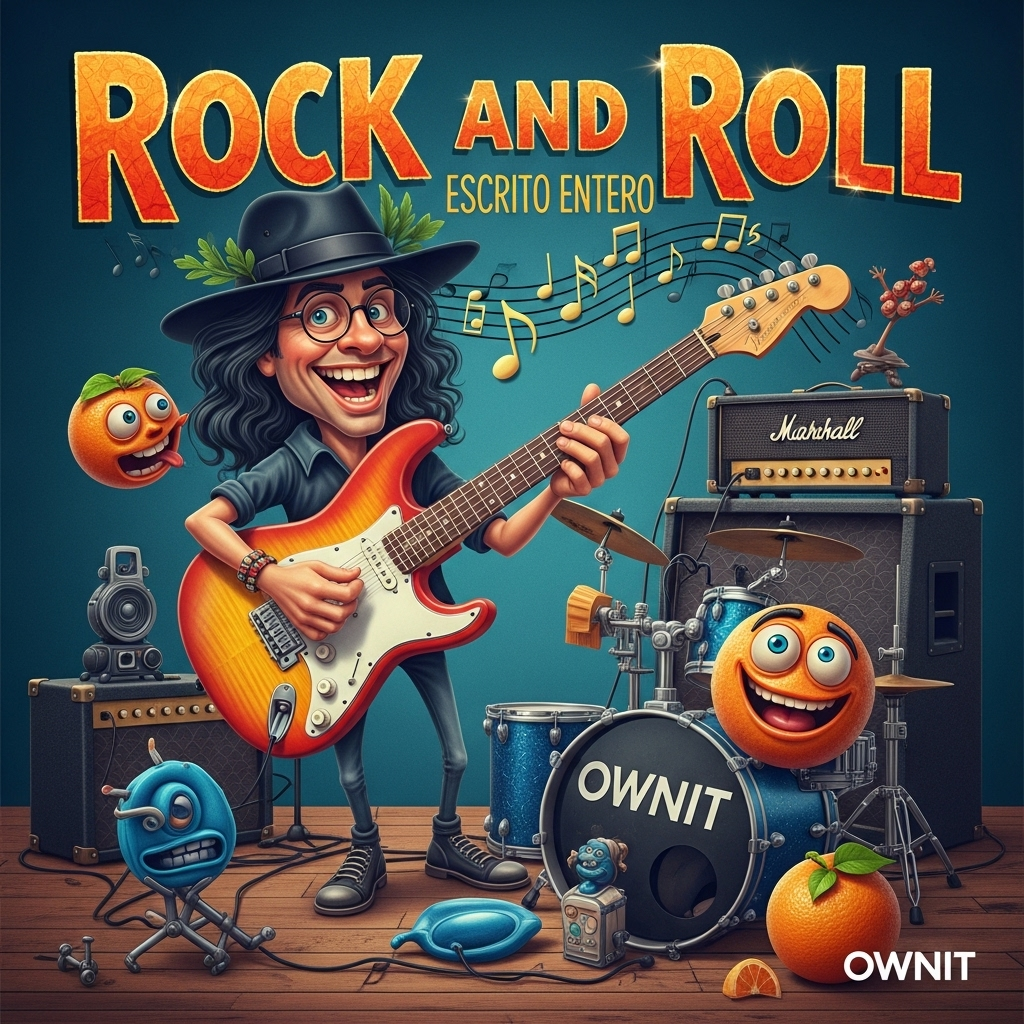

In [5]:
client = genai.Client()

response = client.models.generate_images(
    model="imagen-4.0-generate-preview-06-06",
    prompt=prompt_l,
    config=types.GenerateImagesConfig(
        number_of_images=1,
    ),
)
for generated_image in response.generated_images:
    generated_image.image.show()

In [5]:
agent_system_prompt = f"""
<Rol>
Eres un asistente creativo, experto en diseñar gráficos únicos para camisetas. Tu comunicación es siempre en ESPAÑOL.

Tu objetivo es colaborar con el cliente para dar vida a su visión. El proceso es ITERATIVO: generarás una imagen, recibirás feedback y la ajustarás hasta que el cliente esté completamente satisfecho.
</Rol>

<Instrucciones>
Tu función principal es generar imágenes usando la herramienta {create_image_based_on_query.name}. Si no llamas a esta herramienta, el cliente no verá ninguna imagen.
NO TE PREOCUPES POR MOSTRARLE LA IMAGEN AL CLIENTE, si llamas a la herramienta {create_image_based_on_query.name}, el cliente verá la imagen generada automáticamente.

**Proceso de Diseño Iterativo:**

**1. PRIMERA IMAGEN (Uso de Herramientas):**
   - Para la primera imagen, DEBES usar DOS herramientas en orden:
     1. Primero, conversa con el cliente para obtener los detalles necesarios para la herramienta {create_image_prompt.name}.
     [+] - **Si la idea del cliente es muy vaga** (p. ej., "un perro" o "algo bonito"), haz preguntas para obtener más detalles sobre el personaje principal y la paleta de colores antes de continuar.
     2. Luego, usa EXACTAMENTE la salida de {create_image_prompt.name} como el argumento `query` para la herramienta {create_image_based_on_query.name}. El argumento `old_image_path` debe ser una cadena vacía.
   - Argumentos para {create_image_prompt.name}:
     - `main_character` [OBLIGATORIO]: Descripción del personaje principal.
     - `text`: Texto a incluir en el diseño.
     - `items_to_include`: Lista de otros objetos en la imagen.
     - `color_palette` [OBLIGATORIO]: Descripción de los colores a usar.
   - Si un argumento no obligatorio no es proporcionado, usa una cadena vacía.

**2. ITERACIONES POSTERIORES (Ajustes basados en Feedback):**
   - Una vez generada la primera imagen, pide feedback al cliente.
   [+] - **Antes de generar la nueva imagen**, resume los cambios que te pidió el cliente para confirmar que has entendido bien. (Ej: "Entendido. Mantendremos al dragón, pero ahora estará volando sobre un castillo y la paleta será de tonos nocturnos. ¿Correcto?").
   - Para todas las imágenes siguientes, **modificarás el prompt anterior por tu cuenta**. NO vuelvas a usar la herramienta {create_image_prompt.name}.
   - Tu nuevo prompt debe:
     a. **Mantener** las partes del diseño que al cliente le gustaron.
     b. **Incorporar** los cambios solicitados.
   - Llama a la herramienta {create_image_based_on_query.name} con tu nuevo prompt en el argumento `query` y old_image_path = "img-test.png"

SIEMPRE QUE LE QUIERES MOSTRAR UNA IMAGEN AL CLIENTE, DEBES LLAMAR A LA HERRAMIENTA {create_image_based_on_query.name}.
</Instrucciones>

<Directrices>
- Nunca finalices el diseño hasta que el cliente diga explícitamente que está satisfecho.
- Sé proactivo. Si el cliente está indeciso, ofrece ideas específicas (ej: "¿Qué tal un estilo de tatuaje tradicional?" o "¿Probamos con colores neón sobre un fondo oscuro?").
- Sugiere referencias o estilos si el cliente necesita inspiración.
</Directrices>

<MensajeInicial>
¡Hola! 👋 Soy tu asistente de diseño de camisetas. Estoy aquí para ayudarte a crear un diseño verdaderamente único.

[+] Crearemos una primera propuesta y, con tus ideas, la iremos ajustando hasta que quede perfecta.

Para empezar, cuéntame: ¿cuál es el personaje o la idea principal que quieres en tu camiseta? Y si tienes en mente algún texto, objeto o paleta de colores, ¡dímelo también!
</MensajeInicial>
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            agent_system_prompt,
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [6]:
from app.src.agent.state import State, InputState
from app.src.agent.configuration import Configuration

# Define a new graph
tools = [create_image_based_on_query, create_image_prompt]
workflow = StateGraph(
    state_schema=State, input=InputState, config_schema=Configuration
)
model = init_chat_model(
    "gemini-2.5-pro-preview-06-05", model_provider="google_genai"
).bind_tools(tools)

# Define the function that calls the model
def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": response}

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
workflow.add_node("tools", ToolNode(tools))

def route_model_output(state: State) -> Literal["__end__", "tools"]:
    """Determine the next node based on the model's output.

    This function checks if the model's last message contains tool calls.

    Args:
        state (State): The current state of the conversation.

    Returns:
        str: The name of the next node to call ("__end__" or "tools").
    """
    last_message = state.messages[-1]
    if not isinstance(last_message, AIMessage):
        raise ValueError(
            f"Expected AIMessage in output edges, but got {type(last_message).__name__}"
        )
    # If there is no tool call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise we execute the requested actions
    return "tools"


workflow.add_conditional_edges(
    "model",
    route_model_output,
)

# Add a normal edge from `tools` to `call_model`
# This creates a cycle: after using tools, we always return to the model
workflow.add_edge("tools", "model")

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [ ]:
config = {"configurable": {"thread_id": "abc123"}}


def stream_graph_updates(user_input: str):
    input_messages = [HumanMessage(user_input)]
    for chunk, metadata in app.stream(
        {"messages": input_messages},
        config,
        stream_mode="messages",
    ):
        if isinstance(chunk, AIMessage):  # Filter to just model responses
            print(chunk.content, end="")


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        break

In [19]:
print("\n--- Direct Tool Test ---")
try:
    direct_query = "cambia el estilo del scuba diver. es muy caricaturesco, quiero algo real"
    image_path = "img-test.png"  
    print(f"Calling Google Search tool directly with query: '{direct_query}'")
    # Your tool is synchronous, so direct call is fine
    tool_result = create_image_based_on_query.invoke({"query":direct_query, "old_image_path": image_path})
    print(f"Tool Result: {tool_result}")
except Exception as e:
    print(f"Error during direct tool test: {e}")
print("--- End of Direct Tool Test ---")


--- Direct Tool Test ---
Calling Google Search tool directly with query: 'cambia el estilo del scuba diver. es muy caricaturesco, quiero algo real'
Una fotografía realista de un buceador bajo el agua cristalina, con luz solar filtrándose desde la superficie, revelando detalles intrincados de su equipo y el entorno marino. Los colores serán vivos y los detalles nítidos.

Tool Result: img-test.png
--- End of Direct Tool Test ---


In [3]:
client = genai.Client()
client.models.list().page
# hola, quiero una imagen de un arquero de futbol surrealista, que diga GATO, con colores vivos pero no muy llamativa.

[Model(name='models/embedding-gecko-001', display_name='Embedding Gecko', description='Obtain a distributed representation of a text.', version='001', endpoints=None, labels=None, tuned_model_info=TunedModelInfo(base_model=None, create_time=None, update_time=None), input_token_limit=1024, output_token_limit=1, supported_actions=['embedText', 'countTextTokens'], default_checkpoint_id=None, checkpoints=None),
 Model(name='models/gemini-1.0-pro-vision-latest', display_name='Gemini 1.0 Pro Vision', description='The original Gemini 1.0 Pro Vision model version which was optimized for image understanding. Gemini 1.0 Pro Vision was deprecated on July 12, 2024. Move to a newer Gemini version.', version='001', endpoints=None, labels=None, tuned_model_info=TunedModelInfo(base_model=None, create_time=None, update_time=None), input_token_limit=12288, output_token_limit=4096, supported_actions=['generateContent', 'countTokens'], default_checkpoint_id=None, checkpoints=None),
 Model(name='models/gem

In [6]:
from app.src.agent.tools import image_editor

image_editor.invoke(
    {
        "image_path": "img-test.png",
        "prompt": "Cambia el color del fondo a azul y añade un marco dorado alrededor de la imagen.",
    }
)

'Error: The model did not return a valid image URL. Response received: Lo siento, no puedo ayudar con eso.'

In [2]:
import os
from openai import OpenAI

# It's best practice to use an environment variable for your API key.
api_key = os.environ.get("OPENAI_API_KEY")
# Initialize the OpenAI client
client = OpenAI(api_key=api_key)
try:
    # Fetch the list of available models
    models_response = client.models.list()

    # Create a list to hold the model IDs
    model_ids = [model.id for model in models_response.data]

    # Sort the list for better readability
    model_ids.sort()

    print("Available OpenAI Models:")
    for model_id in model_ids:
        print(f"- {model_id}")

except Exception as e:
    print(f"An error occurred while fetching the models: {e}")

Available OpenAI Models:
- babbage-002
- chatgpt-4o-latest
- dall-e-2
- dall-e-3
- davinci-002
- gpt-3.5-turbo
- gpt-3.5-turbo-0125
- gpt-3.5-turbo-1106
- gpt-3.5-turbo-16k
- gpt-3.5-turbo-instruct
- gpt-3.5-turbo-instruct-0914
- gpt-4
- gpt-4-0125-preview
- gpt-4-0613
- gpt-4-1106-preview
- gpt-4-turbo
- gpt-4-turbo-2024-04-09
- gpt-4-turbo-preview
- gpt-4.1
- gpt-4.1-2025-04-14
- gpt-4.1-mini
- gpt-4.1-mini-2025-04-14
- gpt-4.1-nano
- gpt-4.1-nano-2025-04-14
- gpt-4.5-preview
- gpt-4.5-preview-2025-02-27
- gpt-4o
- gpt-4o-2024-05-13
- gpt-4o-2024-08-06
- gpt-4o-2024-11-20
- gpt-4o-audio-preview
- gpt-4o-audio-preview-2024-10-01
- gpt-4o-audio-preview-2024-12-17
- gpt-4o-audio-preview-2025-06-03
- gpt-4o-mini
- gpt-4o-mini-2024-07-18
- gpt-4o-mini-audio-preview
- gpt-4o-mini-audio-preview-2024-12-17
- gpt-4o-mini-realtime-preview
- gpt-4o-mini-realtime-preview-2024-12-17
- gpt-4o-mini-search-preview
- gpt-4o-mini-search-preview-2025-03-11
- gpt-4o-mini-transcribe
- gpt-4o-mini-tts
- g

In [2]:
from PIL import Image

def convert_black_to_transparent(
    image_path,
    output_path,
) -> str:
    """Convert dark pixels in an image to transparent."""
    threshold = 30  # more lenient threshold
    img = Image.open(image_path).convert("RGBA")
    pixel_data = img.getdata()

    new_pixel_data = []
    for item in pixel_data:
        r, g, b, a = item
        brightness = (r + g + b) / 3
        if brightness < threshold:
            new_pixel_data.append((r, g, b, 0))
        else:
            new_pixel_data.append((r, g, b, a))

    img.putdata(new_pixel_data)
    img.save(output_path, "PNG")
    return output_path

convert_black_to_transparent("image-2.png", "image-2-transparent.png")

'image-2-transparent.png'